# Load data

In [ ]:
from utils import read_EHG, read_EMR
emr = read_EMR.read_EMR('dataset')
ehg = read_EHG.read_EHG('dataset')

In [38]:
import numpy as np
X_ehg = np.array(ehg[-1])
y_binary = np.array(ehg[0])[:, 0]
y_regression = np.array(ehg[0])[:, 1]

# Utils

In [ ]:
import matplotlib.pyplot as plt

def visualize(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['precision'], label='Train Prec')
    plt.plot(history.history['val_precision'], label='Val Prec')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,2,3)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Binary classification

## Split data

In [ ]:
import keras
y = keras.utils.to_categorical(y, num_classes=2)

from sklearn.model_selection import train_test_split

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y, test_size=0.2, random_state=42)
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y, test_size=0.2, random_state=42)

## TCN: temporal convolution neural

In [ ]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    def build(self, input_shape):
        super().build(input_shape)


In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, Callback
import keras.backend as K

# Hàm scheduler
def scheduler(epoch, lr):
    # sau mỗi 5 epoch giảm 0.5
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.5
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

model = MultiInputModelTCN(num_classes=2)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "precision", "recall"])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
1/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1875 - loss: 5.8969 - precision: 0.1875 - recall: 0.1875Epoch 1: lr = 0.001000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1683 - loss: 4.6704 - precision: 0.1683 - recall: 0.1683 - val_accuracy: 0.1923 - val_loss: 3.1747 - val_precision: 0.1923 - val_recall: 0.1923 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1875 - loss: 2.9602 - precision: 0.1875 - recall: 0.1875Epoch 2: lr = 0.001000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1683 - loss: 2.1926 - precision: 0.1683 - recall: 0.1683 - val_accuracy: 0.1923 - val_loss: 1.4472 - val_precision: 0.1923 - val_recall: 0.1923 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
1/7 ━━━━━━━━━━━━━━━━━━━

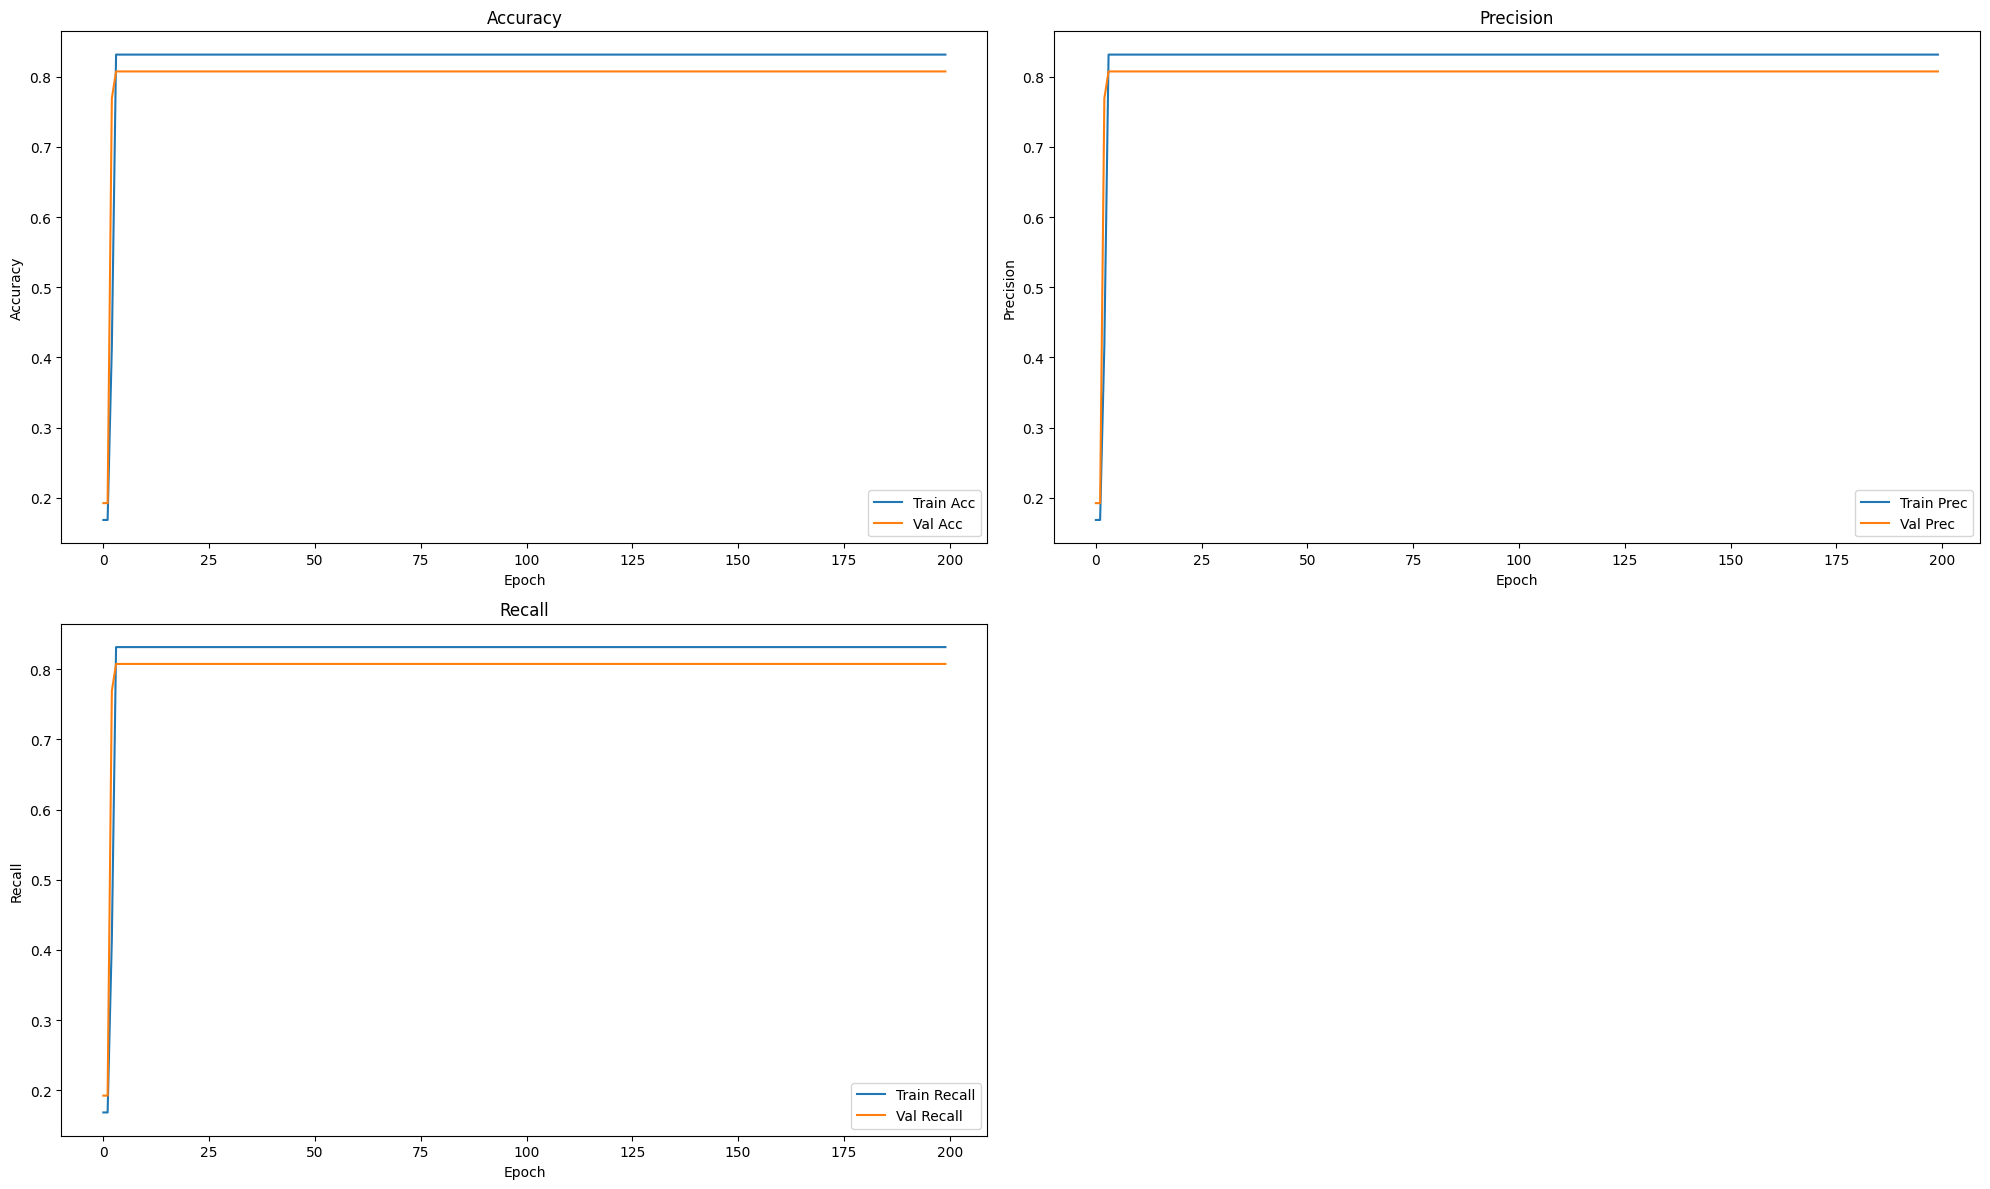

In [ ]:
history = model.fit(
    [X_ehg_train, X_meta_train],
    y_ehg_train,
    batch_size=16,
    validation_split=0.2,
    epochs=200,
    callbacks=[lr_callback, log_callback]
)

In [ ]:
visualize(history= history)

## biLSTM

In [ ]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.4455 - loss: 0.8480 - precision: 0.4455 - recall: 0.4455 - val_accuracy: 0.8077 - val_loss: 0.5000 - val_precision: 0.8077 - val_recall: 0.8077
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8317 - loss: 0.4444 - precision: 0.8317 - recall: 0.8317 - val_accuracy: 0.8077 - val_loss: 0.5104 - val_precision: 0.8077 - val_recall: 0.8077
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8317 - loss: 0.4454 - precision: 0.8317 - recall: 0.8317 - val_accuracy: 0.8077 - val_loss: 0.5199 - val_precision: 0.8077 - val_recall: 0.8077
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8317 - loss: 0.4497 - precision: 0.8317 - recall: 0.8317 - val_accuracy: 0.8077 - val_loss: 0.5248 - val_precision: 0.8077 - val_recall: 0.8077
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8317 - loss: 0.4502 - precision: 0.8317 - recall: 0.8317 - val_accuracy: 0.8077 - val_loss: 0.5230 - val_pre

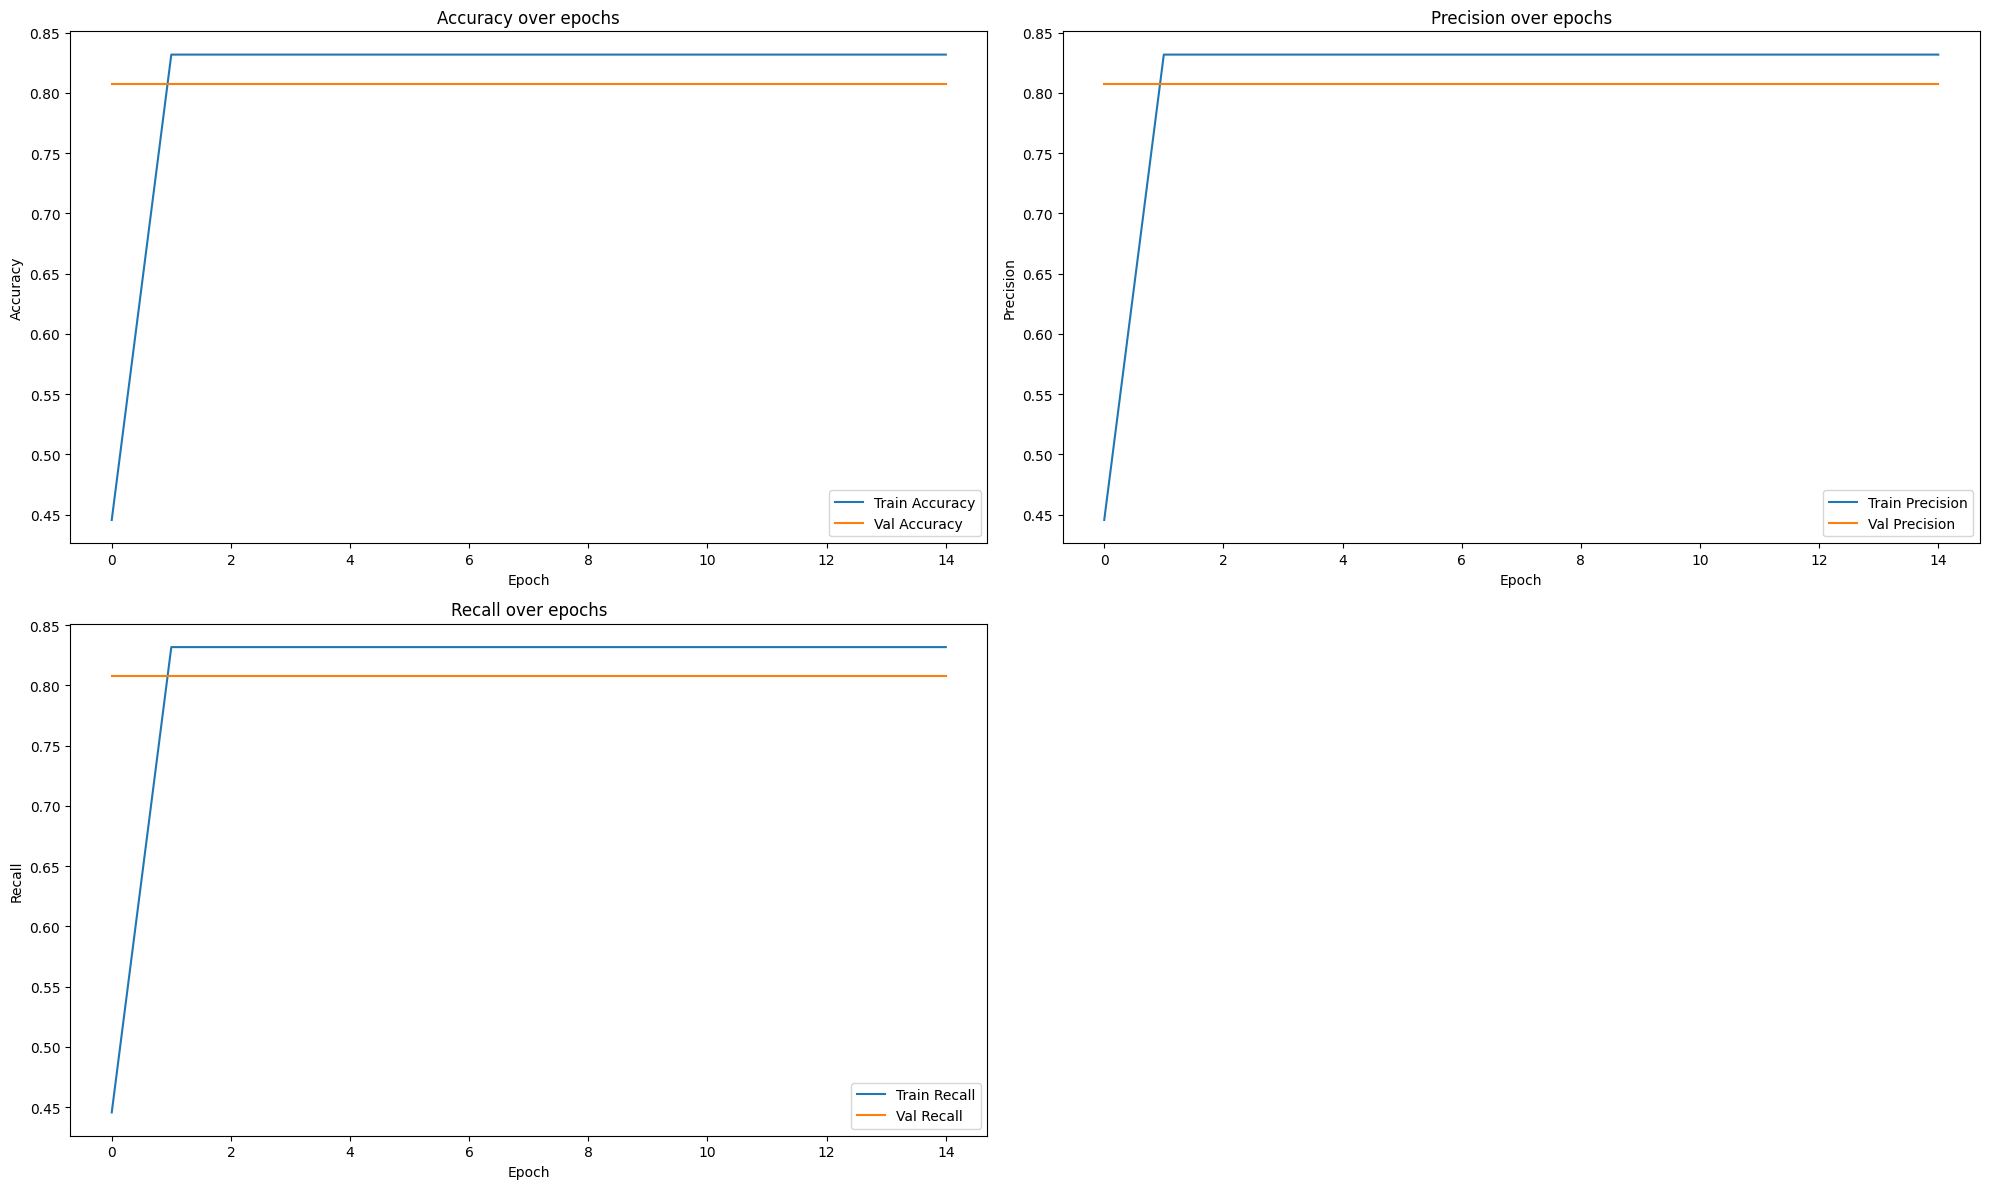

In [ ]:
model = MultiInputModelLSTM(num_classes=2)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "precision", 'recall'])

In [ ]:
history = model.fit([X_ehg_train, X_meta_train], y_ehg_train, batch_size= 16, validation_split= 0.2,  epochs=15)

In [ ]:
visualize(history= history)